<a href="https://colab.research.google.com/github/JoeyMucci/SemanticSegmentationSatelliteImagery/blob/main/ModelCompression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 8.5 MB/s 
Segmentation Models: using `keras` framework.
Now patchifying image: drive/MyDrive/ColabNotebooks/Semantic segmentation dataset/Tile 1/images/image_part_001.jpg
Now patchifying image: drive/MyDrive/ColabNotebooks/Semantic segmentation dataset/Tile 1/images/image_part_002.jpg
Now patchifying image: drive/MyDrive/ColabNotebooks/Semantic segmentation dataset/Tile 1/images/image_part_003.jpg
Now patchifying image: drive/MyDrive/ColabNotebooks/Semantic segmentation dataset/Tile 1/images/image_part_004.jpg
Now patchifying image: drive/MyDrive/ColabNotebooks/Semantic segmentation dataset/Tile 1/images/image_part_005.jpg
Now patchifying image: drive/MyDrive/ColabNotebooks/Semantic segmentation dataset/Tile 1/images/image_part_006.jpg
Now patchi

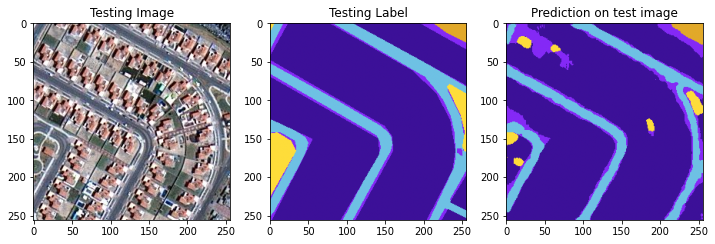

Image Prediction # 2
1/1 [==============================] - 0s 21ms/step


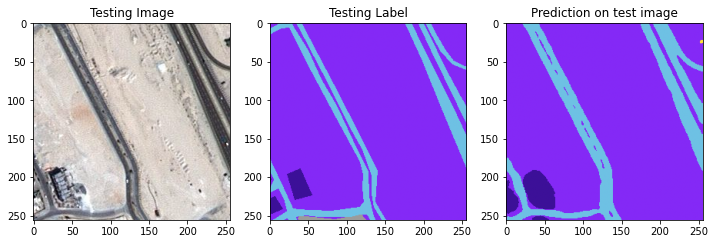

Image Prediction # 3
1/1 [==============================] - 0s 21ms/step


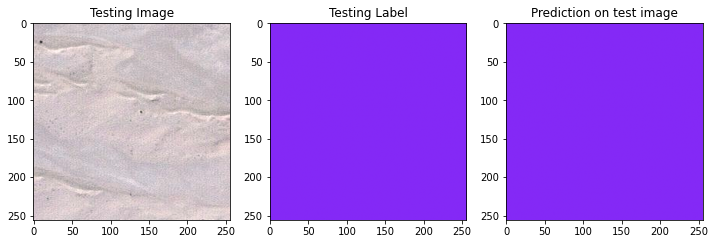

Image Prediction # 4
1/1 [==============================] - 0s 20ms/step


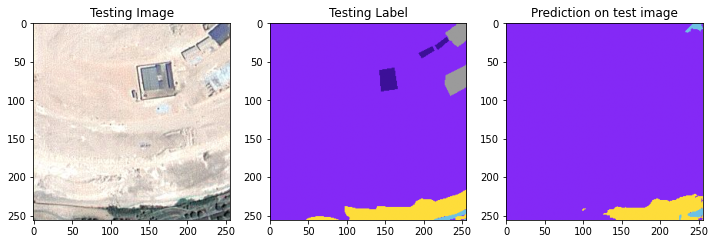

Image Prediction # 5
1/1 [==============================] - 0s 21ms/step


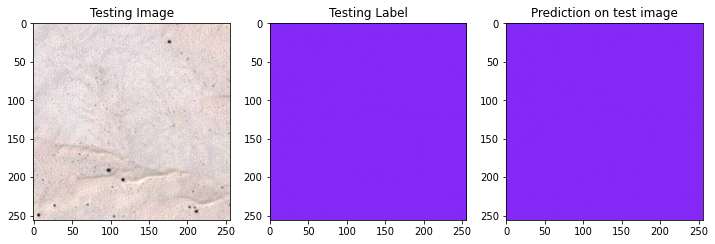

Image Prediction # 6
1/1 [==============================] - 0s 20ms/step


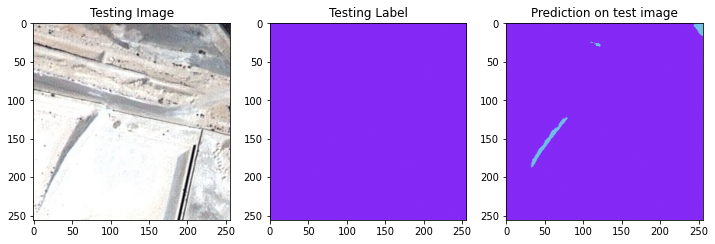

Image Prediction # 7
1/1 [==============================] - 0s 20ms/step


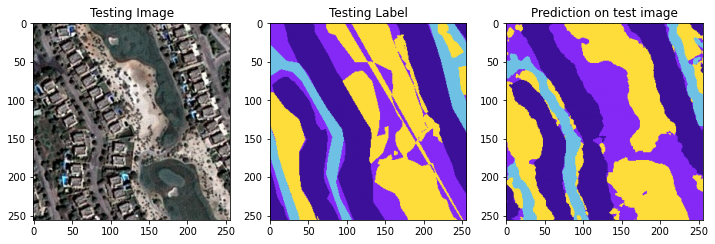

Image Prediction # 8
1/1 [==============================] - 0s 21ms/step


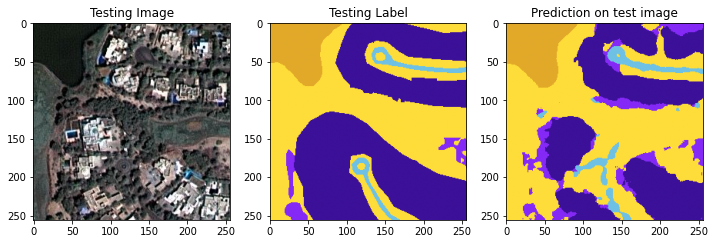

Image Prediction # 9
1/1 [==============================] - 0s 32ms/step


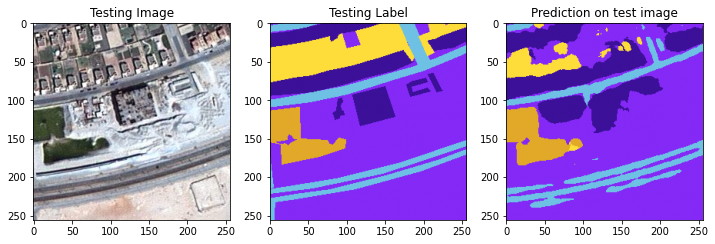

Image Prediction # 10
1/1 [==============================] - 0s 21ms/step


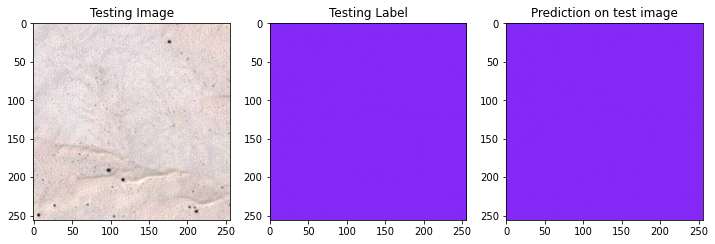

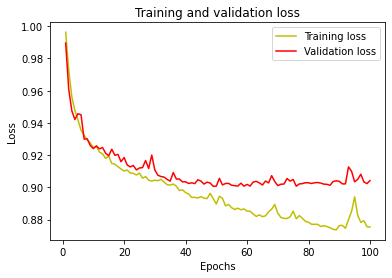

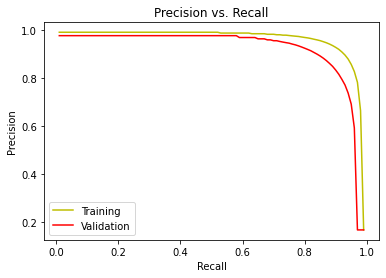

In [2]:
# Originally from DigitalSreeni https://youtu.be/jvZm8REF2KY
import os
import cv2
import numpy as np

!pip install patchify 
!pip install segmentation-models 
import tensorflow as tf
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from keras.metrics.metrics import PrecisionAtRecall

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

root_directory = 'drive/MyDrive/ColabNotebooks/Semantic segmentation dataset/'

patch_size = 256

# Read images into patches and crop
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    subdirs.sort(); # sort the subdirectory so the images and masks match
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   
        images = os.listdir(path)  # list of all image names in this subdirectory
        images.sort() # sort the images so they match with the masks
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):              
                image = cv2.imread(path+"/"+image_name, 1)  

                # get the highest size divisble than 256 but less than the original size
                SIZE_X = (image.shape[1]//patch_size)*patch_size 
                SIZE_Y = (image.shape[0]//patch_size)*patch_size 

                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  # crop from top left corner
                image = np.array(image)             
       
                # extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[i,j,:,:]
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0] # drop the extra unecessary dimension that patchify adds                         
                        image_dataset.append(single_patch_img)
                
# Read corresponding masks into patches and crop
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    subdirs.sort();
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   
        masks = os.listdir(path)  # list of all mask names in this subdirectory
        masks.sort(); # sort the masks so they match with the images
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):     
                mask = cv2.imread(path+"/"+mask_name, 1)  
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)

                # get the highest size divisble than 256 but less than the original size
                SIZE_X = (mask.shape[1]//patch_size)*patch_size 
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size 

                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                mask = np.array(mask)             
       
                # extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size) 
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0] # drop the extra unecessary dimension that patchify adds                             
                        mask_dataset.append(single_patch_mask) 
 
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

# Convert HEX to RGB array
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

# Converts an RGB value to an integer label
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 
# Get categorical labels
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666] # 1/6 = 0.1666
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss) # loss functoin is sum of dice loss and focal loss  

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

path_m = '/content/drive/MyDrive/ColabNotebooks/'
import sys
sys.path.insert(0,path_m)
import simple_multi_unet_model
from simple_multi_unet_model import multi_unet_model
import simple_small_multi_unet_model
from simple_small_multi_unet_model import small_multi_unet_model

recall = [item / 100 for item in range(1, 100)] # Generate range of recall values (0.01-0.99)
metrics = []
for recallVal in recall:
  metrics.append(PrecisionAtRecall(recall = recallVal)) # Define a list of metrics as precision values at a corresponding recall value

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

def get_small_model():
  return small_multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

teacher_model = get_model()
teacher_model.compile(optimizer='adam', loss=total_loss, metrics=metrics)

# Actually run the model
teacher_history = teacher_model.fit(X_train, y_train, 
                    batch_size=16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

# Recolors the images to the original color scheme for easier comprehension
def recolor(old):
  new=np.zeros((256, 256, 3))
  for row in range(256):
    for col in range(256): 
      if(old[row][col] == 0): # Building (Dark Purple)
        new[row][col][0] = 60 / 255
        new[row][col][1] = 16 / 255
        new[row][col][2] = 152 / 255
      elif(old[row][col] == 1): # Land (Bright Purple)
        new[row][col][0] = 132 / 255
        new[row][col][1] = 41 / 255
        new[row][col][2] = 246 / 255
      elif(old[row][col] == 2): # Road (Cyan)
        new[row][col][0] = 110 / 255
        new[row][col][1] = 193 / 255
        new[row][col][2] = 228 / 255
      elif(old[row][col] == 3): # Vegetation (Yellow)
        new[row][col][0] = 254 / 255
        new[row][col][1] = 221 / 255
        new[row][col][2] = 58 / 255
      elif(old[row][col] == 4): # Water (Orange)
        new[row][col][0] = 226 / 255
        new[row][col][1] = 169 / 255
        new[row][col][2] = 41 / 255
      else: # Unlabeled (Gray)
        new[row][col][0] = 155 / 255
        new[row][col][1] = 155 / 255
        new[row][col][2] = 155 / 255
  return new;

# Predict on 10 random images
y_test_argmax=np.argmax(y_test, axis=3)
import random
for i in range(10):
  print("Image Prediction #", (i + 1))
  test_img_number = random.randint(0, len(X_test))
  test_img = X_test[test_img_number]
  ground_truth=y_test_argmax[test_img_number]
  ground_truth_recolor = recolor(ground_truth)
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (teacher_model.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]
  predicted_img_recolor = recolor(predicted_img)
  
  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img)
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(ground_truth_recolor)
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img_recolor)
  plt.show()

# Plot training and validation accuracy as a function of epochs
history = teacher_history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot precision vs recall values for both training and validation sets
precision = [history.history['precision_at_recall'][-1]]
val_precision = [history.history['val_precision_at_recall'][-1]]
for i in range(1, 99):
  precision.append(history.history['precision_at_recall_' + str(i)][-1])
  val_precision.append(history.history['val_precision_at_recall_' + str(i)][-1])
plt.plot(recall, precision, 'y', label = "Training")
plt.plot(recall, val_precision, 'r', label = "Validation")
plt.title("Precision vs. Recall")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [3]:
# Adapted from example of KD on keras website https://keras.io/examples/vision/knowledge_distillation/

# This extends from the model class and overwrites some crucial methods to achieve knowledge distillation
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=1,
        beta=9,
        temperature=3,
    ):

        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.beta = beta
        self.temperature = temperature

    # Calculate gradients and apply updates to model, update metrics
    def train_step(self, data):
        x, y = data

        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)

            student_loss = self.student_loss_fn(y, student_predictions)

            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + self.beta * distillation_loss

        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    # Update the validaton metrics
    def test_step(self, data):
        x, y = data

        y_prediction = self.student(x, training=False)

        student_loss = self.student_loss_fn(y, y_prediction)

        self.compiled_metrics.update_state(y, y_prediction)

        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [12]:
# Set the student to be a smaller model than the teacher (we will compress the cumbersome teacher model into the lightweight student model)
student_model = get_small_model(); 
distiller = Distiller(student=student_model, teacher=teacher_model)
distiller.compile(
    optimizer='adam',
    metrics=[total_loss, metrics],
    student_loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=1,
    beta=9,
    temperature=10,
)

# Distill knowledge from teacher to student
student_history = distiller.fit(X_train, y_train, 
                                batch_size=16,
                                verbose=1, 
                                epochs=100,
                                validation_data = (X_test, y_test),
                                shuffle=False
                                )

Epoch 1/100
66/66 [==============================] - 38s 271ms/step - dice_loss_plus_1focal_loss: 1.0160 - precision_at_recall: 0.9822 - precision_at_recall_1: 0.9822 - precision_at_recall_2: 0.9822 - precision_at_recall_3: 0.9822 - precision_at_recall_4: 0.9822 - precision_at_recall_5: 0.9822 - precision_at_recall_6: 0.9822 - precision_at_recall_7: 0.9760 - precision_at_recall_8: 0.9724 - precision_at_recall_9: 0.9678 - precision_at_recall_10: 0.9618 - precision_at_recall_11: 0.9545 - precision_at_recall_12: 0.9474 - precision_at_recall_13: 0.9390 - precision_at_recall_14: 0.9302 - precision_at_recall_15: 0.9218 - precision_at_recall_16: 0.9137 - precision_at_recall_17: 0.9057 - precision_at_recall_18: 0.8977 - precision_at_recall_19: 0.8903 - precision_at_recall_20: 0.8823 - precision_at_recall_21: 0.8748 - precision_at_recall_22: 0.8663 - precision_at_recall_23: 0.8562 - precision_at_recall_24: 0.8439 - precision_at_recall_25: 0.8288 - precision_at_recall_26: 0.8132 - precision_at_r

Image Prediction # 1
1/1 [==============================] - 0s 21ms/step


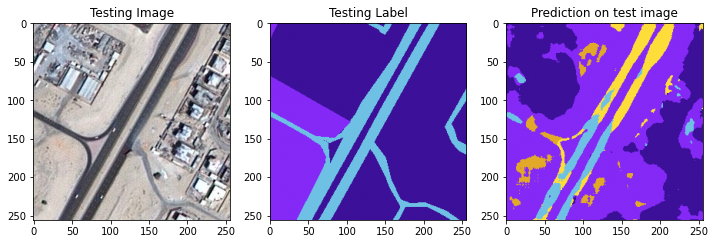

Image Prediction # 2
1/1 [==============================] - 0s 19ms/step


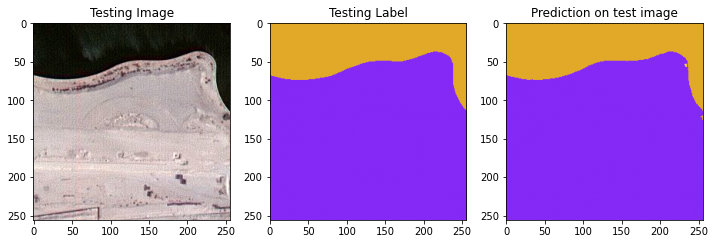

Image Prediction # 3
1/1 [==============================] - 0s 19ms/step


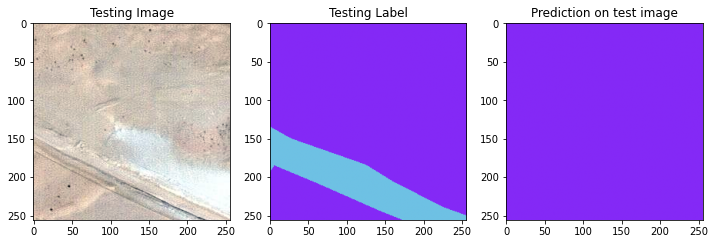

Image Prediction # 4
1/1 [==============================] - 0s 19ms/step


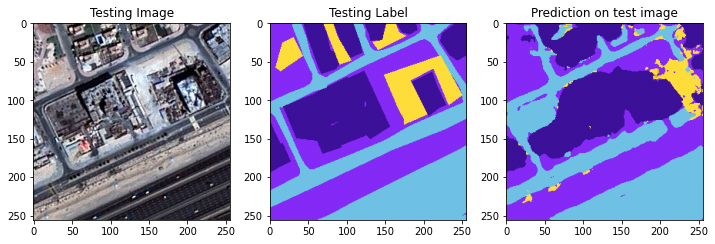

Image Prediction # 5
1/1 [==============================] - 0s 19ms/step


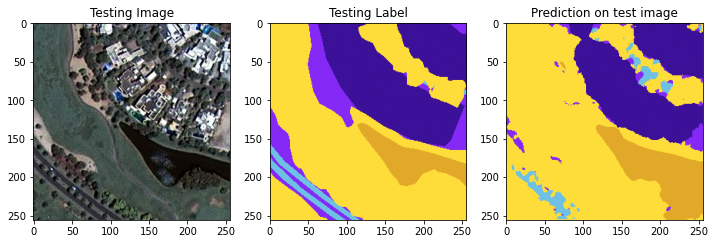

Image Prediction # 6
1/1 [==============================] - 0s 19ms/step


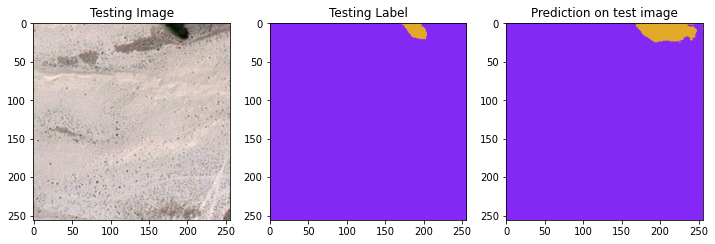

Image Prediction # 7
1/1 [==============================] - 0s 19ms/step


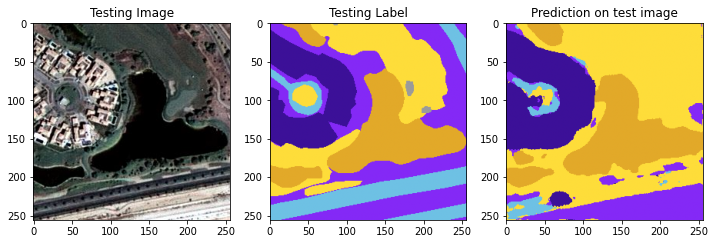

Image Prediction # 8
1/1 [==============================] - 0s 18ms/step


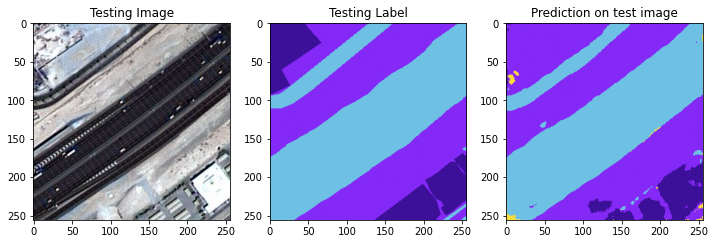

Image Prediction # 9
1/1 [==============================] - 0s 19ms/step


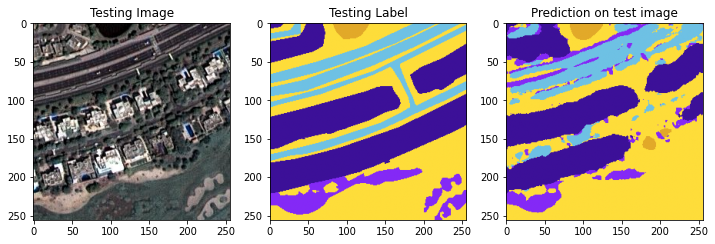

Image Prediction # 10
1/1 [==============================] - 0s 19ms/step


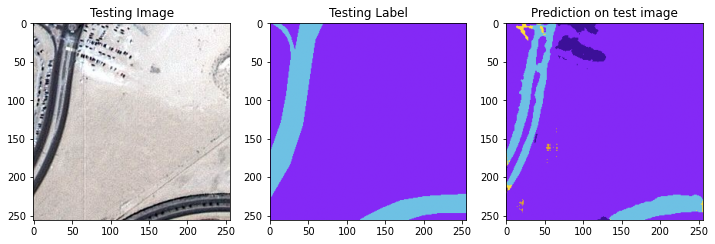

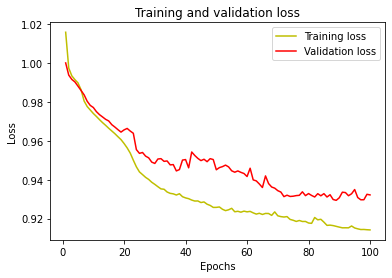

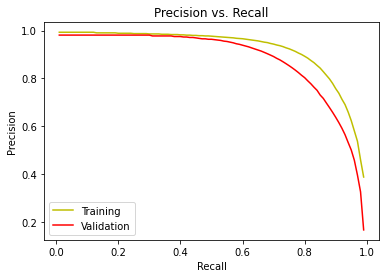

In [48]:
# Predict on 10 random images
import random
for i in range(10):
  print("Image Prediction #", (i + 1))
  test_img_number = random.randint(0, len(X_test) - 1)
  test_img = X_test[test_img_number]
  ground_truth=y_test_argmax[test_img_number]
  ground_truth_recolor = recolor(ground_truth)
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (student_model.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]
  predicted_img_recolor = recolor(predicted_img)
  
  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img)
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(ground_truth_recolor)
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img_recolor)
  plt.show()

# Plot training and validation accuracy as a function of epochs
history = student_history
loss = history.history['dice_loss_plus_1focal_loss']
val_loss = history.history['val_dice_loss_plus_1focal_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot precision vs recall values for both training and validation sets
precision = [history.history['precision_at_recall'][-1]]
val_precision = [history.history['val_precision_at_recall'][-1]]
for i in range(1, 99):
  precision.append(history.history['precision_at_recall_' + str(i)][-1])
  val_precision.append(history.history['val_precision_at_recall_' + str(i)][-1])
plt.plot(recall, precision, 'y', label = "Training")
plt.plot(recall, val_precision, 'r', label = "Validation")
plt.title("Precision vs. Recall")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [49]:
# As you can see the student model has far less trainable paramaters (approximately 1/16), but it was still able to perform well
print("***TEACHER MODEL SUMMARY***")
teacher_model.summary() # 1,941,190 trainable parameters
print("\n\n\n")
print("***STUDENT MODEL SUMMARY***")
student_model.summary() # 121,750 trainable parameters

***TEACHER MODEL SUMMARY***
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                 